## Notebook to run the analysis in the Discussion section of the paper, Fig. 16

In [3]:
from astropy.table import Table
from scipy import interpolate
from astropy.units import Unit
from astropy import constants as const
import itertools
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import log
import seaborn as sns
from matplotlib.colors import LogNorm


In [4]:
def f_t_rise(t_f,t_u,fpars= [0.54, 1.34, 0.25]):
            #[0.54462528, 1.33828366, 0.24756259]):
    return t_u*(fpars[0]+fpars[1]*(t_f/t_u)**(fpars[2]))

def f_t_decay_e(t_f,t_u,fpars=[ 1.00,  1.33,  -1.11]):
            #[ 0.69507366,  1.25703129 ,-1.0834316 ]):
    return t_f*(fpars[0]+fpars[1]*(t_f/t_u)**(fpars[2]))



def f_t_delta(delta,t_f,t_r):
    a=t_r/(t_f-t_r)
    return delta-t_r*log(a)


def lc_pars_from_fit(fit_par,use_t_e=True,src_name=''):
    delta_=ufloat(fit_par['delta'],fit_par['delta_err'])
    t_u_=ufloat(fit_par['t_u'],fit_par['t_u_err'])
    t_f_=ufloat(fit_par['t_f'],fit_par['t_f_err'])
    
    if use_t_e is True:
        t_f_=f_t_decay_e(t_f_,t_u_)
    else:
        t_f_=f_t_decay_t2(t_f_,t_u_)
    
    
    
    delta_t=f_t_delta(delta_,t_f_,t_u_)

    t_decay=f_t_decay_e(t_f_,t_u_)
    t_decay_s = ufloat(0, t_decay.nominal_value*0.01, "u systematic")
    t_decay=t_decay+t_decay_s

    t_rise=f_t_rise(t_f_,t_u_)
    t_rise_s = ufloat(0, t_rise.nominal_value*0.05, "u systematic")
    t_rise=t_rise+t_rise_s
    
    

    return {'src_name':src_name,'delta_t':delta_t,'t_rise':t_rise,'t_decay':t_decay}

In [5]:
data_mrk_421_fit={'t_f':126.5,'t_f_err':.1,'t_u':1.0,'t_u_err':1,'delta':37.4,'delta_err':0.1}
data_mrk_421_lc=lc_pars_from_fit(data_mrk_421_fit,src_name='Mrk 421')

data_mrk_501_fit={'t_f':66.5,'t_f_err':1.5,'t_u':3.4,'t_u_err':1.5,'delta':224,'delta_err':10}
data_mrk_501_lc=lc_pars_from_fit(data_mrk_501_fit,src_name='Mrk 501')

data_3C273_fit={'t_f':30,'t_f_err':3,'t_u':16,'t_u_err':0.5,'delta':264,'delta_err':10}
data_3C273_lc=lc_pars_from_fit(data_3C273_fit,src_name='3C 273')


In [6]:
data_mrk_421_lc

{'src_name': 'Mrk 421',
 'delta_t': 42.23850916461061+/-3.838757588196578,
 't_rise': 5.040861489061932+/-3.931397133721737,
 't_decay': 128.06136591969405+/-2.1567590836812616}

In [7]:
data_mrk_501_lc

{'src_name': 'Mrk 501',
 'delta_t': 234.1025098143365+/-10.429714752478393,
 't_rise': 11.53253047174185+/-4.114827090036915,
 't_decay': 73.00385762092068+/-3.5816442358583163}

In [8]:
data_3C273_lc

{'src_name': '3C 273',
 'delta_t': 275.9935145328598+/-10.086082864586503,
 't_rise': 37.12584414875525+/-2.162641653429612,
 't_decay': 68.63732797119808+/-3.0497350148110365}

In [9]:
def RO_obs_t_obs_decay(t_obs_days,m_B,beta,nu_0,nu_obs,phi):
    return t_obs_days*86400*beta*m_B*const.c.cgs.value/((nu_0/nu_obs)**(phi/m_B))

In [10]:
def RO_obs_t_obs_rise(t_obs_days,m_B,beta,nu_0,nu_obs,phi):
    return t_obs_days*86400*beta*const.c.cgs.value/((nu_0/nu_obs)**(phi/m_B)-1)

In [11]:
def RO_obs_delta_t(t_obs_days,m_B,beta,nu_0,nu_obs,phi,t_exp_obs_days=0):
    return (t_exp_obs_days*84000)+(t_obs_days*86400*beta*const.c.cgs.value/((nu_0/nu_obs)**(phi/m_B)-1))

In [12]:
def delta_t_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,phi,t_exp_obs=0):
    
    return t_exp_obs+t_peak_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,phi)

def t_peak_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,phi):
    a=(R0_obs/(beta_exp*3E10))
    b=(nu_0/nu_obs)**(phi/m_B)
    return a*(b-1)

def t_decay_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,phi):
    a=(R0_obs/(m_B*beta_exp*3E10))
    b=(nu_0/nu_obs)**(phi/m_B)
    return (a*b)

def t_rise_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,phi):
    return t_peak_obs(R0_obs,m_B,beta_exp,nu_0,nu_obs,phi/m_B)/2

In [13]:
def set_value(m_good,v):
    if m_good[0] is None:
        m_good[0]=v
    if m_good[1] is None:
        m_good[1]=v
    #print('%e'%v)
    m_good[1]=max(m_good[1],v)
    m_good[0]=min(m_good[0],v)


In [29]:
def joint_analysis(d1,trend_func,trend_name,label_name,N=20,nu_obs=1.5E10,phi=0.5,skip_trend_plot=True,skip_joint_plot=True,skip_plot=True,n_sigmas=2):
    
    nu_0=np.logspace(np.log10(nu_obs),12,N)


    m_B=np.linspace(1,2,N)
    R0_obs=np.logspace(13,17,N)
    beta=np.logspace(-4,-0.5,N)
    phi=np.logspace(phi-0.1,phi+0.1,N)
    combinations = itertools.product(R0_obs,m_B,beta,phi)

    y = np.zeros((N**4,nu_0.size))
    x=nu_0
    m_B_good=np.array([np.nan]*N**4)
    beta_exp_good=np.array([np.nan]*N**4)
    R_obs_good=np.array([np.nan]*N**4)
    phi_good=np.array([np.nan]*N**4)

    y_lower=d1[trend_name].nominal_value-d1[trend_name].std_dev*n_sigmas
    y_upper=d1[trend_name].nominal_value+d1[trend_name].std_dev*n_sigmas
    for ID, c in enumerate(combinations):
        y[ID]=trend_func(R0_obs=c[0],m_B=c[1],beta_exp=c[2],nu_0=nu_0,nu_obs=nu_obs,phi=c[3])/86400
        msk=np.logical_and(y[ID]<=y_upper,y[ID]>=y_lower)
        for ID_m,m in enumerate(msk):
            if msk[ID_m] == True:
                m_B_good[ID]=c[1]
                beta_exp_good[ID]=c[2]
                R_obs_good[ID]=c[0]
                phi_good[ID]=c[3]
            
    fig=None
    if skip_trend_plot is False and skip_plot is False:
        fig=plt.figure(dpi=100)
        ax=fig.add_subplot()
        y_min=np.amin(y, axis=0)
        y_max=np.amax(y, axis=0)

        ax.fill_between(x,y_max ,y_min ,color='gray',alpha=0.3,label='')

        ax.axhspan(d1[trend_name].nominal_value - d1[trend_name].std_dev, d1[trend_name].nominal_value + d1[trend_name].std_dev, alpha=0.5, color='blue')
        ax.axvline(nu_obs)

        ax.set_ylabel(label_name)
        ax.set_xlabel(r'$\nu^{0,\rm obs}_{\rm SSA}$  (Hz)')


        ax.set_yscale('log')
        ax.set_xscale('log')


    m_B_good=np.array(m_B_good)
    beta_exp_good=np.array(beta_exp_good)
    R_obs_good=np.array(R_obs_good)
   
    
    
    if skip_joint_plot is False and skip_plot is False:
        sns.set(font_scale=1.5)
        f1=sns.jointplot(x=beta_exp_good, y=R_obs_good,kind="kde",log_scale=(True, True), fill=True, levels=50,thresh=0,cmap='RdBu_r',cbar=True)
        f1.set_axis_labels(xlabel=r' $\beta_{\rm exp}$', ylabel=r'$log(R_0^{\rm obs})$ (cm)',fontsize=16)
        pos_joint_ax = f1.ax_joint.get_position()
        pos_marg_x_ax = f1.ax_marg_x.get_position()
        # reposition the joint ax so it has the same width as the marginal x ax
        f1.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
        # reposition the colorbar using new x positions and y positions of the joint ax
        f1.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])
        f1.fig.suptitle(label_name,y=0.9,x=0.9)
        
         # get the current colorbar ticks
        cbar_ticks = f1.fig.axes[-1].get_yticks()
        # get the maximum value of the colorbar
        _, cbar_max = f1.fig.axes[-1].get_ylim()
        # change the labels (not the ticks themselves) to a percentage
        f1.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 1:.1f}' for t in cbar_ticks])

        f2=sns.jointplot(x=beta_exp_good, y=m_B_good,kind="kde",log_scale=(True, False),fill=True,levels=50,thresh=0, cmap='RdBu_r',cbar=True)
        f2.set_axis_labels(xlabel=r' $\beta_{\rm exp}$', ylabel=r'$m_B$',fontsize=16)
        pos_joint_ax = f2.ax_joint.get_position()
        pos_marg_x_ax = f2.ax_marg_x.get_position()
        # reposition the joint ax so it has the same width as the marginal x ax
        f2.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
        # reposition the colorbar using new x positions and y positions of the joint ax
        f2.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])
        f2.fig.suptitle(label_name,y=0.9,x=0.9)
        #fig, ax = plt.subplots(dpi=100)
        # get the current colorbar ticks
        cbar_ticks = f2.fig.axes[-1].get_yticks()
        # get the maximum value of the colorbar
        _, cbar_max = f2.fig.axes[-1].get_ylim()
        # change the labels (not the ticks themselves) to a percentage
        f2.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 1:.1f}' for t in cbar_ticks])


        f3=sns.jointplot(x=R_obs_good, y=m_B_good,kind="kde",log_scale=(True, False),fill=True,levels=50, thresh=0, cmap='RdBu_r',cbar=True)
        f3.set_axis_labels(xlabel=r'$R_0^{\rm obs}$ (cm)', ylabel=r'$m_B$',fontsize=16)
        f3.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
        # reposition the colorbar using new x positions and y positions of the joint ax
        f3.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])
        f3.fig.suptitle(label_name,y=0.9,x=0.9)
        # get the current colorbar ticks
        cbar_ticks = f3.fig.axes[-1].get_yticks()
        # get the maximum value of the colorbar
        _, cbar_max = f3.fig.axes[-1].get_ylim()
        # change the labels (not the ticks themselves) to a percentage
        f3.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 1:.1f}' for t in cbar_ticks])
    
    elif skip_plot is False:
         
        f1=plt.figure(dpi=100)
        ax1=f1.add_subplot()
        ax1.hist(m_B_good,bins=10)
        f2=plt.figure(dpi=100)
        ax2=f2.add_subplot()
        ax2.hist(np.log10(R_obs_good),bins=10)
        f3=plt.figure(dpi=100)
        ax3=f3.add_subplot()
        ax3.hist(np.log10(beta_exp_good),bins=10)
    else:
        f1=None
        f2=None
        f3=None
    
   
    par_space=np.core.records.fromarrays([R_obs_good,m_B_good,beta_exp_good,phi_good],names='R,m_B,beta_exp,phi')
    return fig, f1,f2,f3,par_space

In [25]:
def combined_joint_analysis(par_space_list,src_name):
    
    msk_dict={}
    
    
    for ID,colname in enumerate(par_space_list[0].dtype.names):
        msk=np.ones(par_space_list[0].shape[0],dtype=np.bool)
        #print(colname,msk.sum())
        for par_space in par_space_list:
            _=~np.isnan(par_space[colname])
            msk=np.logical_and(_,msk)
            #print(_.sum())
        msk_dict[colname]=msk
        #print(msk.sum())
    sns.set(font_scale=1.5)
    
    beta_exp_good=np.concatenate( tuple([p['beta_exp'][msk_dict['beta_exp']] for p in par_space_list]))
    R_obs_good=np.concatenate( tuple([p['R'][msk_dict['R']] for p in par_space_list]))
    m_B_good=np.concatenate( tuple([p['m_B'][msk_dict['m_B']] for p in par_space_list]))
    


    
    #print(beta_exp_good)
    f1=sns.jointplot(x=beta_exp_good, y=R_obs_good,kind="kde",log_scale=(True, True), fill=True, levels=50,thresh=0,cmap='RdBu_r',cbar=False)
    f1.set_axis_labels(xlabel=r' $\beta_{\rm exp}$', ylabel=r'$log(R_0^{\rm obs})$ (cm)',fontsize=18)
    pos_joint_ax = f1.ax_joint.get_position()
    pos_marg_x_ax = f1.ax_marg_x.get_position()
    
    # reposition the joint ax so it has the same width as the marginal x ax
    #f1.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    
    # reposition the colorbar using new x positions and y positions of the joint ax
    #f1.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])
    f1.fig.suptitle(src_name,y=0.9,x=0.95)
    f1.fig.set_dpi(100)
    # get the current colorbar ticks
    #cbar_ticks = f1.fig.axes[-1].get_yticks()
    
    # get the maximum value of the colorbar
    # _, cbar_max = f1.fig.axes[-1].get_ylim()
    
    # change the labels (not the ticks themselves) to a percentage
    #f1.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 1:.1f}' for t in cbar_ticks])

    f2=sns.jointplot(x=beta_exp_good, y=m_B_good,kind="kde",log_scale=(True, False),fill=True,levels=50,thresh=0, cmap='RdBu_r',cbar=False)
    f2.set_axis_labels(xlabel=r' $\beta_{\rm exp}$', ylabel=r'$m_B$',fontsize=18)
    pos_joint_ax = f2.ax_joint.get_position()
    pos_marg_x_ax = f2.ax_marg_x.get_position()
    
    # reposition the joint ax so it has the same width as the marginal x ax
    #f2.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    
    # reposition the colorbar using new x positions and y positions of the joint ax
    #f2.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])
    f2.fig.suptitle(src_name,y=0.9,x=0.95)
    f2.fig.set_dpi(100)
    #fig, ax = plt.subplots(dpi=100)
    
    # get the current colorbar ticks
    #cbar_ticks = f2.fig.axes[-1].get_yticks()
    
    # get the maximum value of the colorbar
    #_, cbar_max = f2.fig.axes[-1].get_ylim()
    
    # change the labels (not the ticks themselves) to a percentage
    #f2.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 1:.1f}' for t in cbar_ticks])


    f3=sns.jointplot(x=R_obs_good, y=m_B_good,kind="kde",log_scale=(True, False),fill=True,levels=50, thresh=0, cmap='RdBu_r',cbar=True)
    f3.set_axis_labels(xlabel=r'$R_0^{\rm obs}$ (cm)', ylabel=r'$m_B$',fontsize=18)
    f3.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    # reposition the colorbar using new x positions and y positions of the joint ax
    f3.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])
    f3.fig.suptitle(src_name,y=0.9,x=0.95)
    # get the current colorbar ticks
    cbar_ticks = f3.fig.axes[-1].get_yticks()
    # get the maximum value of the colorbar
    _, cbar_max = f3.fig.axes[-1].get_ylim()
    # change the labels (not the ticks themselves) to a percentage
    f3.fig.axes[-1].set_yticklabels([f'{t / cbar_max * 1:.1f}' for t in cbar_ticks])
    f3.fig.set_dpi(100)
    
    return  f1,f2,f3

In [26]:
def do_single_time_scale_analysis(data_fit_lc,N=10,n_sigmas=2,skip_plot=False,save_fig=False,skip_joint_plot=True):
    name=data_fit_lc['src_name'].replace(' ','')
    f,f1,f2,f3,par_space_t_rise=joint_analysis(data_fit_lc,t_rise_obs,'t_rise',r'$t_{\rm rise}^{\rm obs}$',N=N,n_sigmas=n_sigmas,skip_plot=skip_plot,skip_joint_plot=skip_joint_plot)
    if f1 is not None and save_fig is True:
        f1.savefig('Estimate_par_from_obs/data_%s_t_rise_c.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        f2.savefig('Estimate_par_from_obs/data_%s_t_rise_a.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        f3.savefig('Estimate_par_from_obs/data_%s_t_rise_b.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
    
    f,f1,f2,f3,par_space_delta_t=joint_analysis(data_fit_lc,delta_t_obs,'delta_t',r' $\Delta t^{\rm obs}$',N=N,n_sigmas=n_sigmas,skip_plot=skip_plot,skip_joint_plot=skip_joint_plot)
    if f1 is not None and save_fig is True:        
        f1.savefig('Estimate_par_from_obs/data_%s_delta_t_c.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        f2.savefig('Estimate_par_from_obs/data_%s_delta_t_a.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        f3.savefig('Estimate_par_from_obs/data_%s_delta_t_b.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        
    f,f1,f2,f3,par_space_t_decay=joint_analysis(data_fit_lc,t_decay_obs,'t_decay',r'$t_{\rm decay}^{\rm obs}$',N=N,n_sigmas=n_sigmas,skip_plot=skip_plot,skip_joint_plot=skip_joint_plot)
    if f1 is not None and save_fig is True:
        f1.savefig('Estimate_par_from_obs/data_%s_t_dec_c.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        f2.savefig('Estimate_par_from_obs/data_%s_t_dec_a.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
        f3.savefig('Estimate_par_from_obs/data_%s_t_dec_b.png'%name,bbox_inches = 'tight',
            pad_inches = 0)
    
    return par_space_t_rise,par_space_delta_t,par_space_t_decay

In [27]:
def do_combined_time_scale_analysis(par_space_list,src_name,N=10,n_sigmas=2):
   
    
    f1,f2,f3=combined_joint_analysis(par_space_list,src_name)
    src_name=src_name.replace(' ','')
    if f1 is not None:
        f1.savefig('Estimate_par_from_obs/data_%s_analysis_c.png'%src_name,bbox_inches = 'tight',
            pad_inches = 0)
        f2.savefig('Estimate_par_from_obs/data_%s_analysis_a.png'%src_name,bbox_inches = 'tight',
            pad_inches = 0)
        f3.savefig('Estimate_par_from_obs/data_%s_analysis_b.png'%src_name,bbox_inches = 'tight',
            pad_inches = 0)
    
   
    
    return None

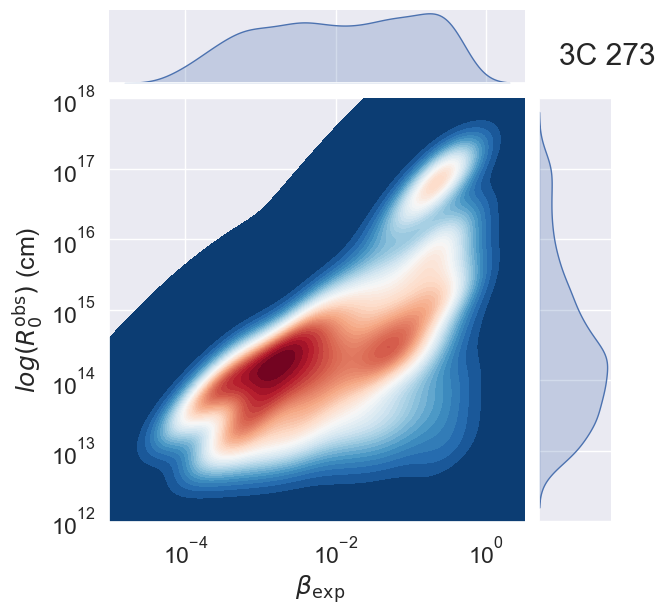

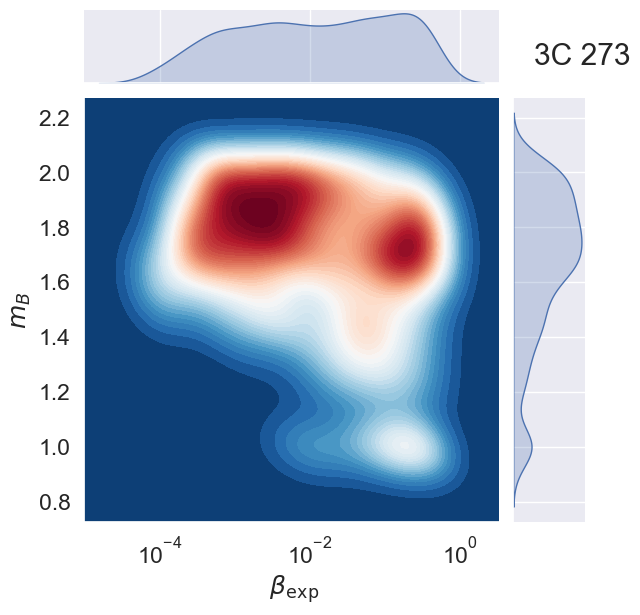

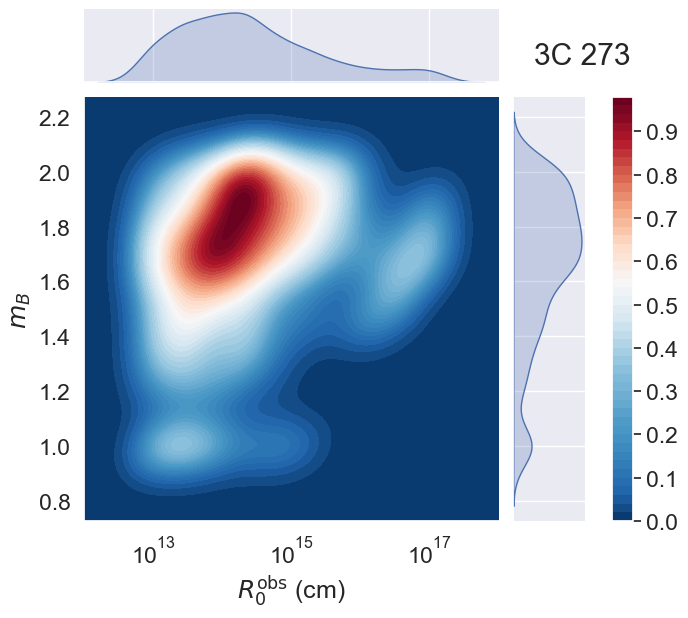

In [30]:
par_space_t_rise_3C273,par_space_delta_t_3C273,par_space_t_decay_3C273=do_single_time_scale_analysis(data_3C273_lc,n_sigmas=2,N=10,skip_plot=True)
do_combined_time_scale_analysis([par_space_t_rise_3C273,par_space_t_decay_3C273,par_space_t_decay_3C273],'3C 273')

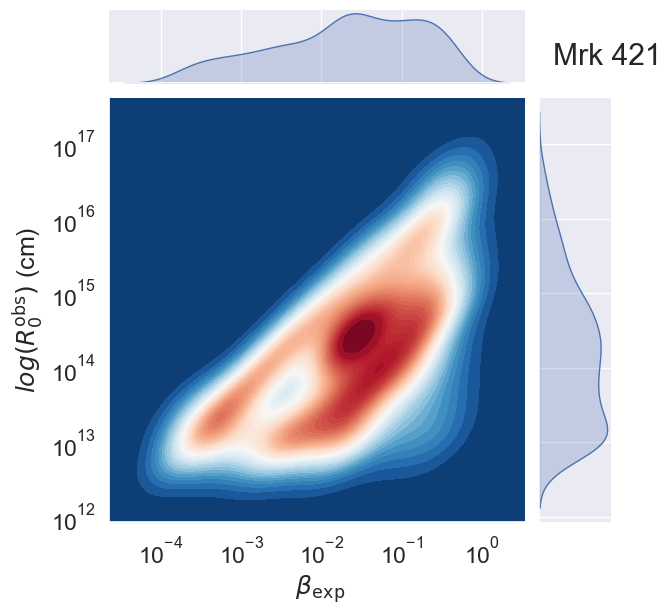

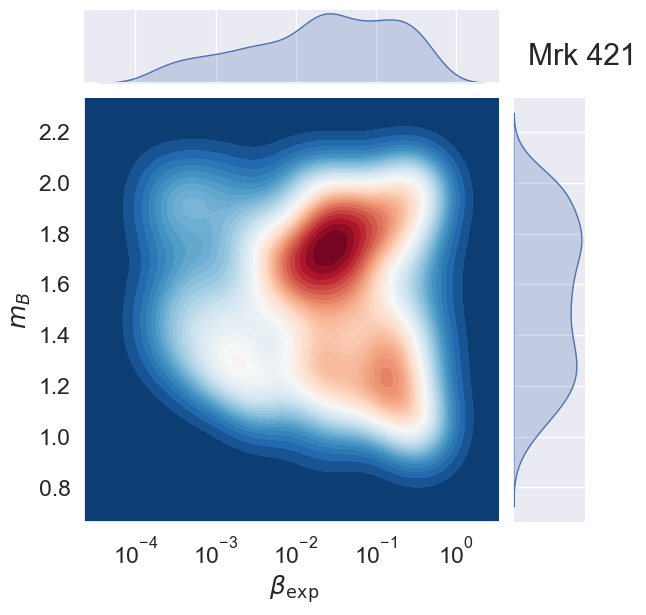

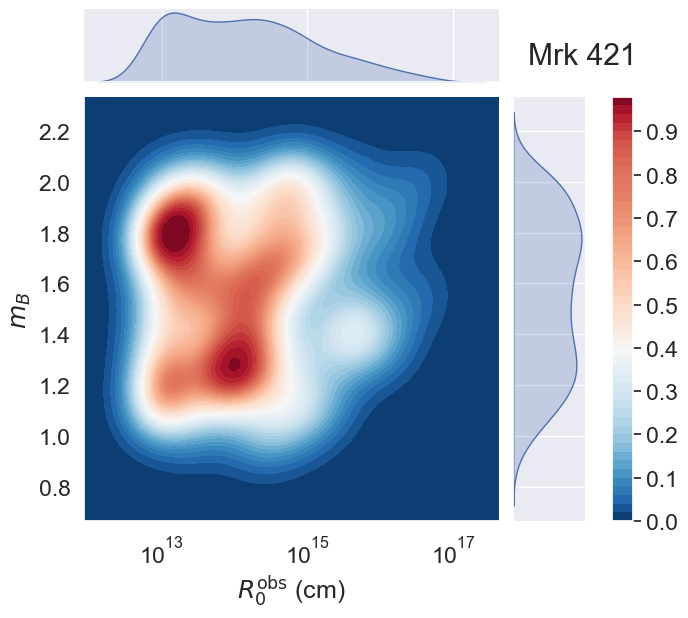

In [31]:
par_space_t_rise_mrk_421,par_space_delta_t_mrk_421,par_space_t_decay_mrk_421=do_single_time_scale_analysis(data_mrk_421_lc,N=10,n_sigmas=2,skip_plot=True)
do_combined_time_scale_analysis([par_space_t_decay_mrk_421,par_space_t_rise_mrk_421,par_space_delta_t_mrk_421],'Mrk 421')

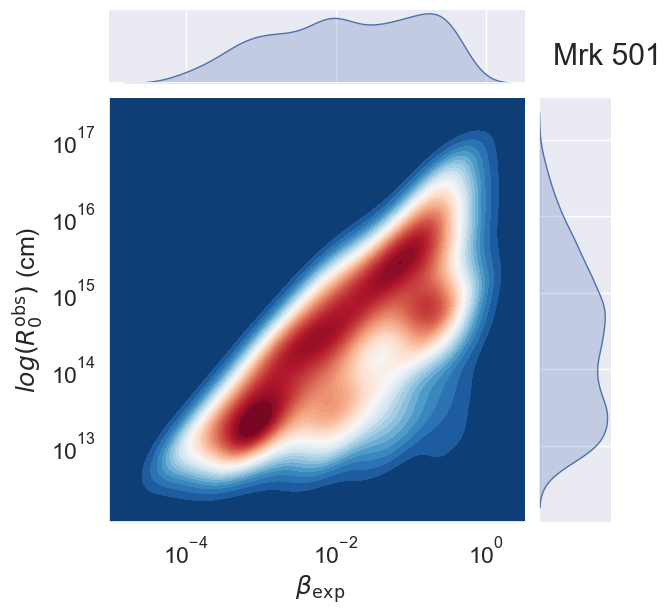

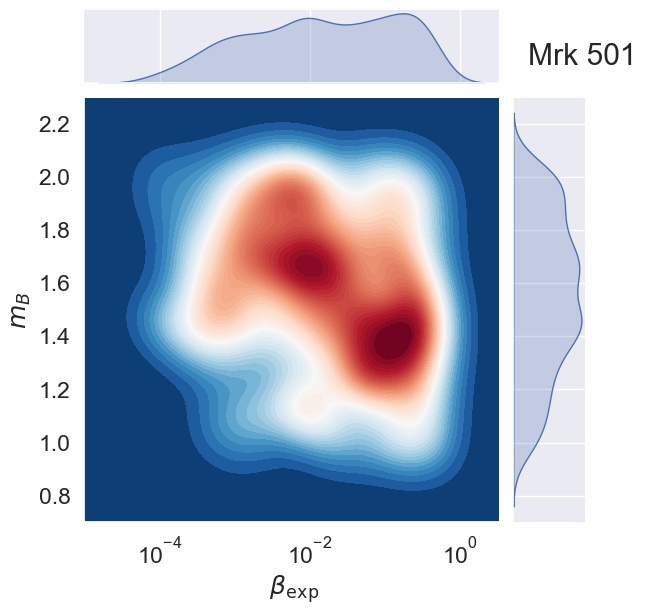

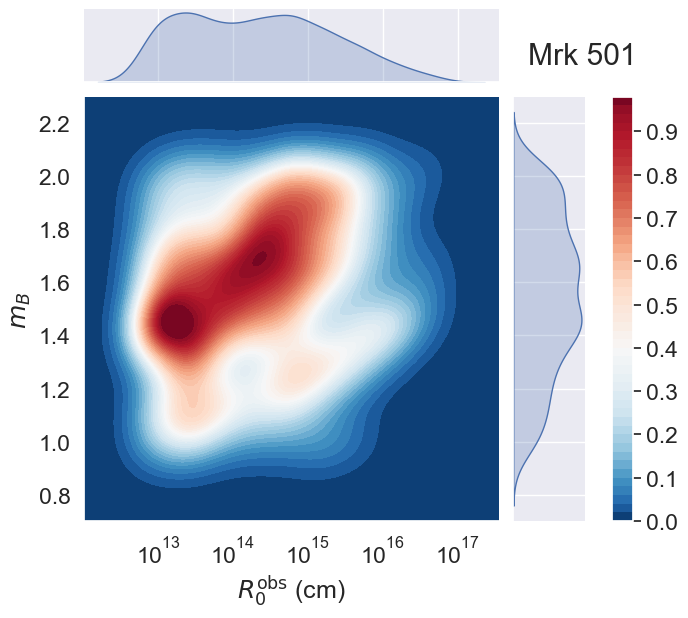

In [32]:
par_space_t_rise_mrk_501,par_space_delta_t_mrk_501,par_space_t_decay_mrk_501=do_single_time_scale_analysis(data_mrk_501_lc,N=10,n_sigmas=2,skip_plot=True)
do_combined_time_scale_analysis([par_space_t_rise_mrk_501,par_space_t_decay_mrk_501,par_space_delta_t_mrk_501],src_name='Mrk 501')

In [742]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import gca


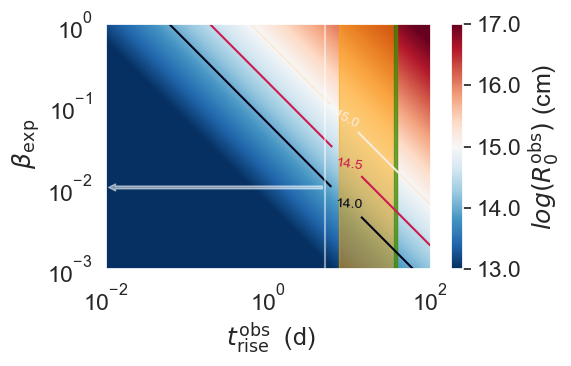

In [18]:

N=1000
m_B=1
beta=np.logspace(-3,0,N)
nu_0=1E11
phi= 0.5
t_range_days=np.logspace(-2,2,N)
X, Y = np.meshgrid(t_range_days, beta)
Z=RO_obs_t_obs_rise(X,m_B,Y,nu_0=nu_0,nu_obs=1.5E10,phi=phi)
fig, ax = plt.subplots(dpi=100)
#CS = ax.pcolormesh(X, Y, Z,levels=np.logspace(-1,3,10),alpha=0.8,cmap=cm.viridis)
CS = ax.contour(X, Y, np.log10(Z),levels=np.arange(14,15.5,.5))
ax.clabel(CS, inline=True, fontsize=10,fmt='%1.1f',manual=((10,0.1),(10,0.01),(10,0.01)),use_clabeltext=False)
CS1=ax.pcolormesh(X, Y, np.log10(Z),
                       norm=colors.Normalize(vmin=13, vmax=17),
                       cmap='RdBu_r', shading='auto')
cbar = fig.colorbar(CS1,format='%2.1f')
cbar.ax.set_ylabel(r'$log(R_0^{\rm obs})$ (cm)')

#ax.axvline(1, alpha=0.5, color='white')
ax.axvline(data_mrk_421_lc['t_rise'].nominal_value, alpha=0.5, color='white')

opt = dict(color='white', 
            arrowstyle = 'simple,head_width=.5,head_length=.5',
            connectionstyle = 'arc3,rad=-0',alpha=0.5)
a2  = gca().annotate('',xy=(1E-2,1E-2), xycoords='data',xytext =(data_mrk_421_lc['t_rise'].nominal_value,1E-2),textcoords = 'data',arrowprops=opt,size=10)


#ax.axvspan(3.3-2.5,3.3+2.17, alpha=0.5, color='orange')
#ax.axvspan(16.1-0.7,16.1+0.6, alpha=0.5, color='green')

ax.axvspan(data_mrk_501_lc['t_rise'].nominal_value-data_mrk_501_lc['t_rise'].std_dev,data_3C273_lc['t_rise'].nominal_value+data_3C273_lc['t_rise'].std_dev, alpha=0.5, color='orange')
ax.axvspan(data_3C273_lc['t_rise'].nominal_value-data_3C273_lc['t_rise'].std_dev,data_3C273_lc['t_rise'].nominal_value+data_3C273_lc['t_rise'].std_dev, alpha=0.5, color='green')

ax.set_xlabel(r' $t_{\rm rise}^{\rm obs}$  (d)')
ax.set_ylabel(r' $\beta_{\rm exp}$')
#ax.set_xlim(-0.2)
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

In [10]:
fig.savefig('Estimate_par_from_obs/t_rise_data_comp.png',bbox_inches = 'tight',
    pad_inches = 0)


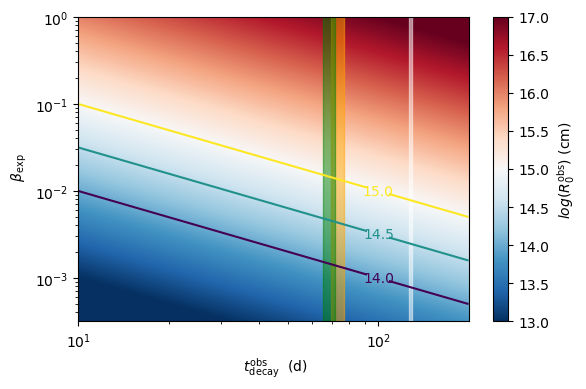

In [54]:
N=1000
m_B=1
beta=np.logspace(-3.5,0,N)
nu_0=1E11
phi= 0.5
t_range_days=np.logspace(1,2.3,N)
X, Y = np.meshgrid(t_range_days, beta)
Z=RO_obs_t_obs_decay(X,m_B=m_B,beta=Y,nu_0=nu_0,nu_obs=1.5E10,phi=phi)
fig, ax = plt.subplots(dpi=100)
#CS = ax.pcolormesh(X, Y, Z,levels=np.logspace(-1,3,10),alpha=0.8,cmap=cm.viridis)
CS = ax.contour(X, Y, np.log10(Z),levels=np.arange(14,15.5,.5))
ax.clabel(CS, inline=True, fontsize=10,fmt='%1.1f',manual=((100,0.1),(100,0.01),(100,0.01)))
CS1=ax.pcolormesh(X, Y, np.log10(Z),
                       norm=colors.Normalize(vmin=13, vmax=17),
                       cmap='RdBu_r', shading='auto')
cbar = fig.colorbar(CS1,format='%2.1f')
cbar.ax.set_ylabel(r'$log(R_0^{\rm obs})$ (cm)')


ax.axvspan(data_mrk_421_lc['t_decay'].nominal_value - data_mrk_421_lc['t_decay'].std_dev, data_mrk_421_lc['t_decay'].nominal_value + data_mrk_421_lc['t_decay'].std_dev, alpha=0.5, color='white')
ax.axvspan(data_mrk_501_lc['t_decay'].nominal_value - data_mrk_501_lc['t_decay'].std_dev, data_mrk_501_lc['t_decay'].nominal_value + data_mrk_501_lc['t_decay'].std_dev, alpha=0.5, color='orange')
ax.axvspan(data_3C273_lc['t_decay'].nominal_value - data_3C273_lc['t_decay'].std_dev,data_3C273_lc['t_decay'].nominal_value + data_3C273_lc['t_decay'].std_dev, alpha=0.5, color='green')
#ax.axvspan(122.5-2.11, 122.5+2.11, alpha=0.5, color='white')
#ax.axvspan(66.5-0.49,66.5+1.5, alpha=0.5, color='orange')
#ax.axvspan(30.1-2.1,30.1+2.9, alpha=0.5, color='green')
ax.set_xlabel(r' $t_{\rm decay}^{\rm obs}$  (d)')
ax.set_ylabel(r' $\beta_{\rm exp}$')
#ax.set_xlim(0.1)
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

In [12]:
fig.savefig('Estimate_par_from_obs/t_dec_data_comp.png',bbox_inches = 'tight',
    pad_inches = 0)

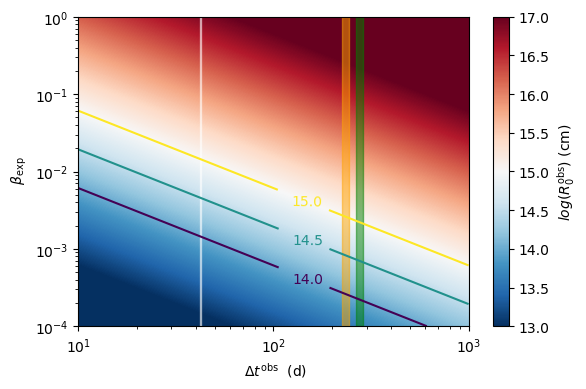

In [55]:
N=1000
m_B=1
beta=np.logspace(-4,0,N)
nu_0=1E11
phi= 0.5
t_range_days=np.logspace(1,3,N)
X, Y = np.meshgrid(t_range_days, beta)
Z=RO_obs_delta_t(X,m_B,Y,nu_0=nu_0,nu_obs=1.5E10,phi=phi)
fig, ax = plt.subplots(dpi=100)
CS = ax.contour(X, Y, np.log10(Z),levels=np.arange(14,15.5,.5))
ax.clabel(CS, inline=True, fontsize=10,fmt='%1.1f',manual=((150,0.1),(150,0.01),(150,0.001)),use_clabeltext=True)
CS1=ax.pcolormesh(X, Y, np.log10(Z),
                       norm=colors.Normalize(vmin=13, vmax=17),
                       cmap='RdBu_r', shading='auto')
cbar = fig.colorbar(CS1,format='%2.1f')
cbar.ax.set_ylabel(r'$log(R_0^{\rm obs})$ (cm)')


ax.axvspan(data_mrk_421_lc['delta_t'].nominal_value - data_mrk_421_lc['delta_t'].std_dev, data_mrk_421_lc['delta_t'].nominal_value + data_mrk_421_lc['delta_t'].std_dev, alpha=0.5, color='white')
ax.axvspan(data_mrk_501_lc['delta_t'].nominal_value - data_mrk_501_lc['delta_t'].std_dev, data_mrk_501_lc['delta_t'].nominal_value + data_mrk_501_lc['delta_t'].std_dev, alpha=0.5, color='orange')
ax.axvspan(data_3C273_lc['delta_t'].nominal_value - data_3C273_lc['delta_t'].std_dev,data_3C273_lc['delta_t'].nominal_value + data_3C273_lc['delta_t'].std_dev, alpha=0.5, color='green')
#ax.axvspan(38.4-1.3, 38.4+1.3, alpha=0.5, color='white')
#ax.axvspan(224.2-3.9,224.2+3.1, alpha=0.5, color='orange')
#ax.axvspan(264.3-6.5,264.3+6.2, alpha=0.5, color='green')
ax.set_xlabel(r' $\Delta t^{\rm obs}$  (d)')
ax.set_ylabel(r' $\beta_{\rm exp}$')
#ax.set_xlim(-0.2)
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

In [14]:
fig.savefig('Estimate_par_from_obs/delta_t_data_comp.png',bbox_inches = 'tight',
    pad_inches = 0)

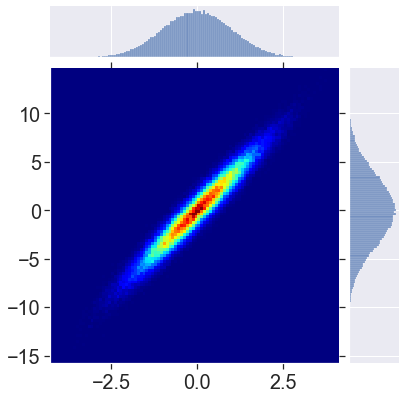

In [773]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# some random data
x = np.random.normal(size=100000)
y = x * 3.5 + np.random.normal(size=100000)

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.hist2d(x, y, bins=(100, 100), cmap=cm.jet,norm=None);